In [ ]:
import pandas as pd
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
import numpy as np

Read csv

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/opera-dl/data/opera_dataset_1w_10min.csv',parse_dates=['timestamp']).set_index('timestamp')
df2 = pd.read_csv('/content/drive/My Drive/opera-dl/data/opera_dataset_3w_30min.csv',parse_dates=['timestamp']).set_index('timestamp')
df3 = pd.read_csv('/content/drive/My Drive/opera-dl/data/opera_dataset_3w_90min.csv',parse_dates=['timestamp']).set_index('timestamp')


Model, parameters and cross-validation definition

In [ ]:
cv_n=30
dataframes = [df1, df2, df3]
scenarios = ["10min","10min+10min+10min","10min+20min+60min"]
regr=neighbors.KNeighborsRegressor()
regr.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Iterate cross validation for the 3 scenarios

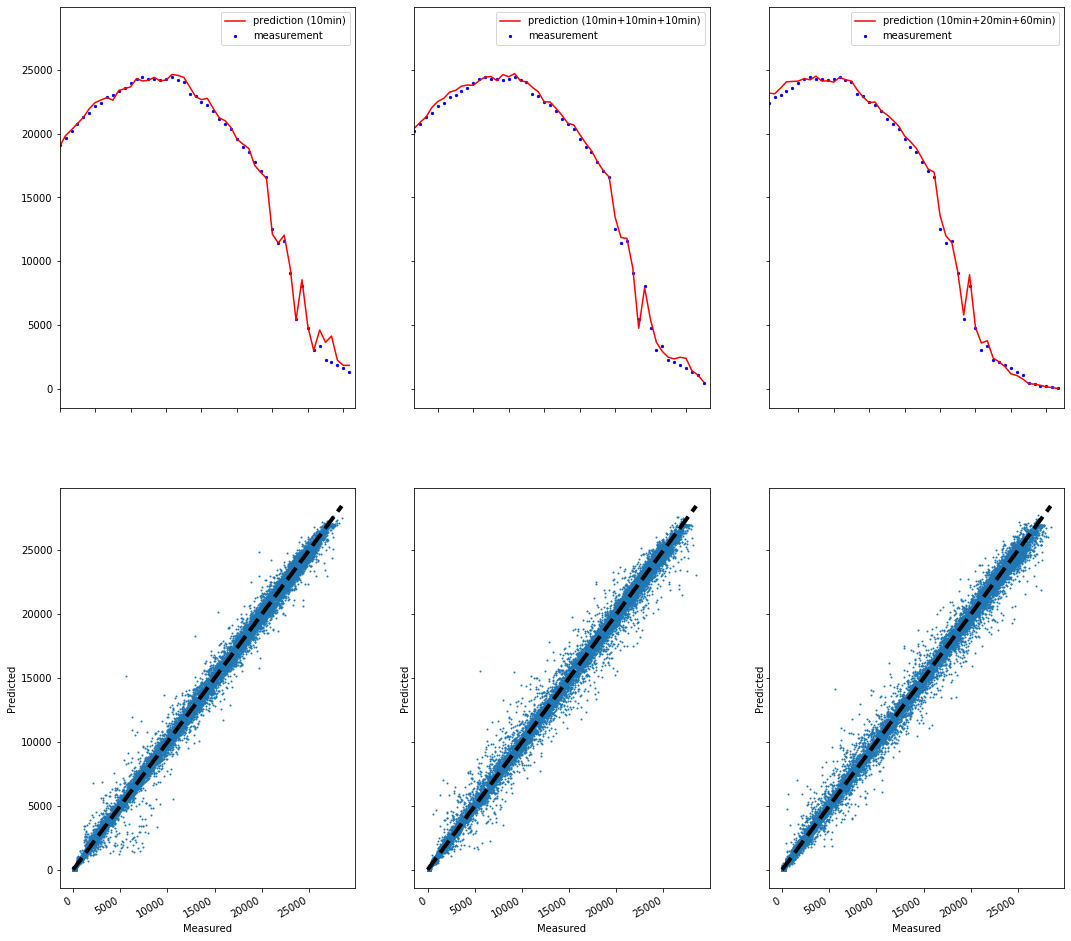

In [ ]:
benchmark_error=np.empty([3, 3])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 18), sharey=True)
xplot_min = 12570
xplot_max = 12620

for ix,df in enumerate(dataframes): 
  X = df.drop('Pa1', axis=1)
  y = df['Pa1']

  scores_predict = cross_val_predict(regr, X, y, cv=cv_n)

  benchmark_error[ix][0] = mean_squared_error(y,scores_predict,squared=False)
  benchmark_error[ix][1] = mean_absolute_error(y,scores_predict)
  benchmark_error[ix][2] = r2_score(y,scores_predict)


  axes[0,ix].scatter(X.index[xplot_min:xplot_max],y[xplot_min:xplot_max],color="blue",label="measurement",s=5)
  axes[0,ix].plot(X.index[xplot_min:xplot_max],scores_predict[xplot_min:xplot_max], color="red",label="prediction ("+scenarios[ix]+")")
  axes[0,ix].legend()
  axes[0,ix].set_xlim(X.index[xplot_min],X.index[xplot_max])
  axes[1,ix].set_xlabel('Time')
  axes[1,ix].set_ylabel('Power')  

  axes[1,ix].scatter(y, scores_predict, s=1)
  axes[1,ix].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
  axes[1,ix].set_xlabel('Measured')
  axes[1,ix].set_ylabel('Predicted')  

fig.autofmt_xdate()
plt.show()


error Metrics

In [ ]:
benchmark_err_df_headers=["RMSE (W)","MAE (W)", "r2"]
benchmark_err_df = pd.DataFrame(data=benchmark_error,index=scenarios,columns=benchmark_err_df_headers)
benchmark_err_df.to_csv('/content/drive/My Drive/Profesional/_Proyecto Ópera/Data Science/knn_error_bm.csv')
benchmark_err_df


,RMSE (W),MAE (W),r2
10min,466.756912,229.624988,0.997193
10min+10min+10min,536.113205,249.290811,0.996297
10min+20min+60min,528.398894,253.126340,0.996400


Performance 

In [ ]:
benchmark_performance=np.empty([3, 3])

for ix,df in enumerate(dataframes): 
  X = df.drop('Pa1', axis=1)
  y = df['Pa1']

  scores_eval = cross_validate(regr, X, y, cv=cv_n)

  benchmark_performance[ix][0] = scores_eval['fit_time'].mean()
  benchmark_performance[ix][1] = scores_eval['score_time'].mean()
  benchmark_performance[ix][2] = scores_eval['test_score'].mean()




Performance metrics

In [ ]:
benchmark_perf_df_headers=["fit_time (s)","score_time (s)","test_score"]
benchmark_perf_df = pd.DataFrame(data=benchmark_performance,index=scenarios,columns=benchmark_perf_df_headers)
benchmark_perf_df.to_csv('/content/drive/My Drive/Profesional/_Proyecto Ópera/Data Science/knn_performance_bm.csv')
benchmark_perf_df



,fit_time (s),score_time (s),test_score
10min,0.086518,0.012996,0.996023
10min+10min+10min,0.213547,0.051496,0.994619
10min+20min+60min,0.196538,0.052109,0.994922


Anomalies???

In [ ]:
diff = (y - scores_predict)[lambda x : abs(x)>5000]
diff



timestamp
2019-06-14 11:10:00+00:00    5562.986091
2019-07-13 11:40:00+00:00    5057.563344
2019-09-13 16:50:00+00:00   -5428.018476
2019-09-13 17:00:00+00:00   -5310.711678
2019-11-05 13:10:00+00:00   -8613.200022
Name: Pa1, dtype: float64

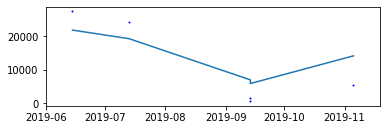

In [ ]:
df['Pred']=scores_predict


ax1 = plt.subplot(211)
plt.scatter(diff.index,df['Pa1'][diff.index], color='blue',s=1)
plt.plot(diff.index,df['Pred'][diff.index])


